<a href="https://colab.research.google.com/github/Manujeet7/Pneumonia_Detectinon/blob/master/pneumonia_detection_inception_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import numpy as np
import pandas as pd
import skimage
import os
import cv2
import tqdm

In [2]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manujeet10","key":"36eabbf41660e8866358541323db4b5d"}'}

In [3]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 66 Sep 27 18:10 kaggle.json


In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets list -s pneumonia

ref                                                               title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
paultimothymooney/chest-xray-pneumonia                            Chest X-Ray Images (Pneumonia)                        1GB  2018-03-24 19:41:59          23206  
parthachakraborty/pneumonia-chest-x-ray                           Pneumonia Chest X ray                                 1GB  2018-08-16 07:48:39            359  
vaillant/rsna-pneu-train-png                                      RSNA Pneumonia Detection Challenge Train PNGs         9GB  2018-09-21 00:02:41            198  
nih-chest-xrays/data                                              NIH Chest X-rays                                     42GB  2018-02-21 20:52:23          25982  
nih-chest-xrays/sample      

In [7]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 1.15G/1.15G [00:20<00:00, 47.1MB/s]



In [8]:
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray.zip          


In [9]:
!unzip chest_xray.zip -d chest-xray-pneumonia

Archive:  chest_xray.zip
   creating: chest-xray-pneumonia/chest_xray/
  inflating: chest-xray-pneumonia/chest_xray/.DS_Store  
   creating: chest-xray-pneumonia/__MACOSX/
   creating: chest-xray-pneumonia/__MACOSX/chest_xray/
  inflating: chest-xray-pneumonia/__MACOSX/chest_xray/._.DS_Store  
   creating: chest-xray-pneumonia/chest_xray/test/
  inflating: chest-xray-pneumonia/chest_xray/test/.DS_Store  
   creating: chest-xray-pneumonia/__MACOSX/chest_xray/test/
  inflating: chest-xray-pneumonia/__MACOSX/chest_xray/test/._.DS_Store  
   creating: chest-xray-pneumonia/chest_xray/test/PNEUMONIA/
  inflating: chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
   creating: chest-xray-pneumonia/__MACOSX/chest_xray/test/PNEUMONIA/
  inflating: chest-xray-pneumonia/__MACOSX/chest_xray/test/PNEUMONIA/._person147_bacteria_706.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: chest-xray-pneumonia/__MACOSX/ches

In [0]:
!rm chest-xray-pneumonia.zip
!rm chest_xray.zip

In [0]:
train_direc = "./chest-xray-pneumonia/chest_xray/train/"
validation_direc = "./chest-xray-pneumonia/chest_xray/val/"
test_direc = "./chest-xray-pneumonia/chest_xray/test/"

In [12]:
print(os.listdir("./chest-xray-pneumonia/chest_xray"))

['.DS_Store', 'train', 'val', 'test']


In [13]:
print(os.listdir("./chest-xray-pneumonia/chest_xray/train"))

['.DS_Store', 'NORMAL', 'PNEUMONIA']


In [0]:
display_p_samples = "./chest-xray-pneumonia/chest_xray/train/PNEUMONIA/"
display_n_samples = "./chest-xray-pneumonia/chest_xray/train/NORMAL/"

In [15]:
p_samples = os.listdir(display_p_samples)[:8]
p_samples

['person1429_bacteria_3691.jpeg',
 'person899_virus_1553.jpeg',
 'person516_virus_1033.jpeg',
 'person1295_virus_2223.jpeg',
 'person975_virus_1650.jpeg',
 'person760_virus_1388.jpeg',
 'person1666_bacteria_4416.jpeg',
 'person1215_bacteria_3167.jpeg']

In [16]:
n_samples = os.listdir(display_n_samples)[:8]
n_samples

['NORMAL2-IM-0815-0001.jpeg',
 'IM-0481-0001.jpeg',
 'NORMAL2-IM-0535-0001-0002.jpeg',
 'IM-0672-0001.jpeg',
 'NORMAL2-IM-1243-0001.jpeg',
 'NORMAL2-IM-0493-0001.jpeg',
 'NORMAL2-IM-0651-0004.jpeg',
 'NORMAL2-IM-1142-0001-0002.jpeg']

In [0]:
def plot_normal_chestxray():
    global n_samples
    fig = plt.figure(figsize=(10,5))
    fig.suptitle('NORMAL_CHEST_XRAY', fontsize=16)

    n_samples = list(filter(lambda x: x != '.DS_Store', n_samples))
    for im, num in zip(n_samples, list(range(len(n_samples)))):
        ax = fig.add_subplot(2,4,num+1)
        img = cv2.imread(os.path.join(display_n_samples, im))
        ax.imshow(img)
        ax.set_title(num+1)
    
    plt.tight_layout()
    plt.show()

In [0]:
def plot_pneumonia_chestxray():
    global p_samples
    fig = plt.figure(figsize=(10,5))
    fig.suptitle('PNEUMONIA_CHEST_XRAY', fontsize=16)

    p_samples = list(filter(lambda x: x != '.DS_Store', p_samples))
    for im, num in zip(p_samples, list(range(len(p_samples)))):
        ax = fig.add_subplot(2,4,num+1)
        img = cv2.imread(os.path.join(display_p_samples, im))
        ax.imshow(img)
        ax.set_title(num+1)
    
    plt.tight_layout()
    plt.show()

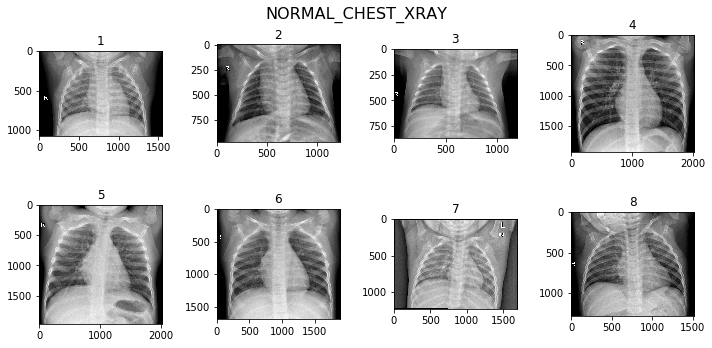

In [19]:
plot_normal_chestxray()

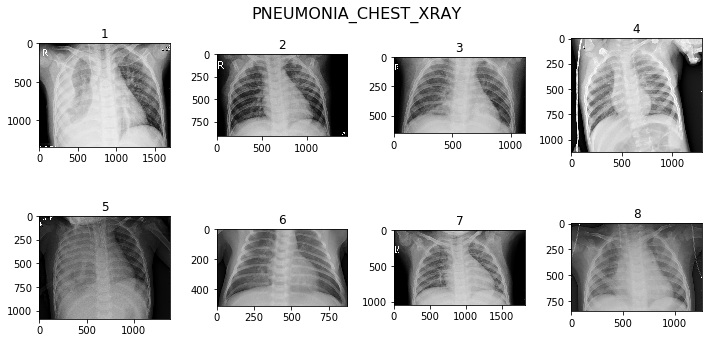

In [20]:
plot_pneumonia_chestxray()

In [0]:
#Preparing data for ImageDataGenerator

def extract_data(path_directory):
    X = []
    y = []
    for nextdirectory in os.listdir(path_directory):
        if not nextdirectory.startswith('.'):
            if nextdirectory in ['NORMAL']:
                label = 0
            elif nextdirectory in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = path_directory + nextdirectory
                
            for file in tqdm.tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [22]:
X_train, y_train = extract_data(train_direc)

100%|██████████| 3876/3876 [11:39<00:00,  5.54it/s]


In [23]:
X_test, y_test = extract_data(test_direc)

100%|██████████| 390/390 [00:59<00:00,  7.03it/s]


In [24]:
X_train.shape, y_train.shape

((5216, 150, 150, 3), (5216,))

In [25]:
X_test.shape, y_test.shape

((624, 150, 150, 3), (624,))

In [0]:
import tensorflow
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

In [0]:
savepath="pneumonia_inceptionv3_weights.hdf5"
checkpoint = ModelCheckpoint(savepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Dense , Activation
from tensorflow.keras.layers import Dropout , GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD , RMSprop , Adadelta , Adam
from tensorflow.keras.layers import Conv2D , BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import backend as K
K.set_image_data_format('channels_first')
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [0]:
X_train=X_train.reshape(5216,3,150,150)
X_test=X_test.reshape(624,3,150,150)

In [31]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
# create the base pre-trained model
base_model = InceptionV3(weights=None, include_top=False , input_shape=(3, 150, 150))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='sigmoid')(x)

In [0]:
#Combining the base model Inceptionv3 and our output layers binary class prediction
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])

In [35]:
# Inception v3 architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 150, 150) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 74, 74)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 74, 74)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 74, 74)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
batch_size = 256
epochs = 10

In [37]:
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,
          epochs=epochs)

Train on 5216 samples, validate on 624 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10


InvalidArgumentError: ignored

In [0]:
base_model.load_weights("inception_v3_weights.h5")

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

In [0]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [0]:
PREDICTION_PATH = 'chest_xray/test/'
fig = plt.figure(figsize=(10,10))
for im, lab, num in zip(X_test[:5], y_test[:5], range(len(X_test[:5]))):
    ax = fig.add_subplot(5,1,num+1)
    ax.imshow(im.reshape(150,150,3))
    ax.set_title(f'Predicted Value:{pred[num]}, Real Value:{lab}')

plt.tight_layout()
plt.show()